In [3]:
import os
import random
import json
from PIL import Image, ImageDraw, ImageFont

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from datasets import Dataset, Features, Value, ClassLabel, Sequence, Array2D, Array3D
from transformers import AutoProcessor
import torch
import evaluate

RANDOM_STATE = 1992
random.seed(RANDOM_STATE)
TRAIN_DEV_SET_SIZE = 120

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Filter out the train/dev set and create a Pandas DataFrame

In [4]:
def create_dataframe(root_folder):
    data = []
    
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file != '.DS_Store':
                target = os.path.basename(root)
                filename = file
                relative_path = os.path.relpath(os.path.join(root_folder, root, file), root_folder)
                data.append((filename, target, relative_path))
    
    df = pd.DataFrame(data, columns=['filename', 'target', 'relative_path'])
    return df

In [5]:
df = create_dataframe('docs-sm')

df = shuffle(df)

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
print(test_df.shape)

train_df = train_df.reset_index()

df.to_csv('raw_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)
train_df.to_csv('train_dataset.csv', index=False)

# Collect all labels and create id2label and label2id dicts
labels = list(set(train_df['target'].to_list()))
id2label = {k: v for k,v in enumerate(labels)}
label2id = {v: k for k,v in enumerate(labels)}

with open("labels.json", "w") as f:
    json.dump(labels, f)

with open("id2label.json", "w") as f:
    json.dump(id2label, f)

with open("label2id.json", "w") as f:
    json.dump(label2id, f)

train_df['enc_target'] = train_df.target.map(lambda x : label2id[x])
display(train_df)

(498, 3)


,index,filename,target,relative_path,enc_target
0,4878,ti17150023.jpg,budget,docs-sm/budget/ti17150023.jpg,3
1,3231,2051161002.jpg,file_folder,docs-sm/file_folder/2051161002.jpg,0
2,3175,2063243333.jpg,file_folder,docs-sm/file_folder/2063243333.jpg,0
3,638,522718272+-8272.jpg,handwritten,docs-sm/handwritten/522718272+-8272.jpg,5
4,1649,2069722762.jpg,specification,docs-sm/specification/2069722762.jpg,13
...,...,...,...,...,...
4474,738,518302406+-2407.jpg,handwritten,docs-sm/handwritten/518302406+-2407.jpg,5
4475,1682,0000046991.jpg,specification,docs-sm/specification/0000046991.jpg,13
4476,3150,2504200012.jpg,file_folder,docs-sm/file_folder/2504200012.jpg,0
4477,4699,ti16681417.jpg,budget,docs-sm/budget/ti16681417.jpg,3


In [6]:
test_df['target'].value_counts()

target
questionnaire             41
form                      39
scientific_publication    38
file_folder               36
specification             34
advertisement             32
budget                    32
email                     32
resume                    31
handwritten               30
scientific_report         30
invoice                   28
letter                    27
presentation              25
news_article              22
memo                      21
Name: count, dtype: int64

Selected image class: resume


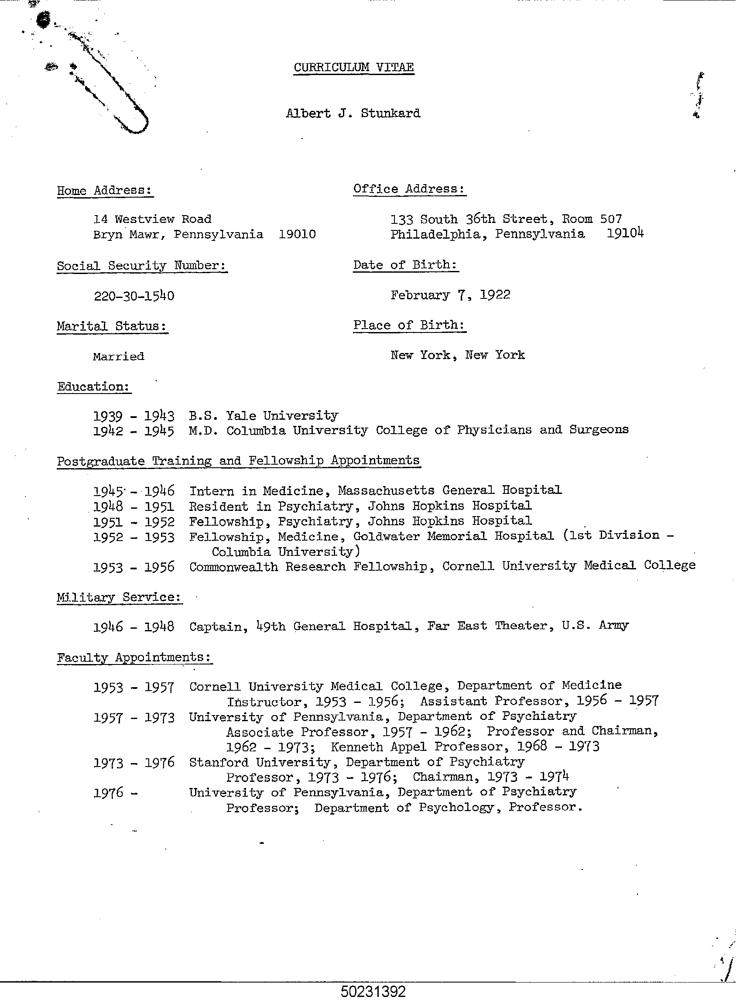

In [7]:
idx = 45
print(f'Selected image class: {train_df.loc[idx, 'target']}')

image = Image.open(train_df.loc[idx, 'relative_path'])
image = image.convert("RGB")
image

In [8]:
raw_dataset = Dataset.from_pandas(train_df, features=Features({'index': Value(dtype='int64', id=None),
                                                                'filename': Value(dtype='string', id=None),
                                                                'target':  ClassLabel(names=labels),
                                                                'relative_path': Value(dtype='string', id=None),
                                                                'enc_target': Value(dtype='int64', id=None)}))

raw_dataset

Dataset({
    features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
    num_rows: 4479
})

In [9]:
raw_dataset.features

{'index': Value(dtype='int64', id=None),
 'filename': Value(dtype='string', id=None),
 'target': ClassLabel(names=['file_folder', 'letter', 'advertisement', 'budget', 'form', 'handwritten', 'invoice', 'presentation', 'resume', 'questionnaire', 'scientific_publication', 'email', 'memo', 'specification', 'news_article', 'scientific_report'], id=None),
 'relative_path': Value(dtype='string', id=None),
 'enc_target': Value(dtype='int64', id=None)}

### Run OCR on images. Extract HF input meta data. I use LayoutLMv3 processor with OCR (this use pytessaract and extract every meta data directly from the input image)

In [10]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=True)

In [11]:
encoded_inp = processor(image, return_tensors="pt")

In [12]:
encoded_inp.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

In [13]:
len(encoded_inp['input_ids'][0]), len(encoded_inp['attention_mask'][0]), len(encoded_inp['bbox'][0])

(318, 318, 318)

In [14]:
for k,v in encoded_inp.items():
  print(k, v.shape)

input_ids torch.Size([1, 318])
attention_mask torch.Size([1, 318])
bbox torch.Size([1, 318, 4])
pixel_values torch.Size([1, 3, 224, 224])


In [15]:
processor.tokenizer.decode(encoded_inp.input_ids.squeeze().tolist())

'<s> CURRICULUM VITAE Palen, Albert J. Stunkera Home Address: Office Address 14 Westview Road 133 South 36th Street, Room 507 Bryn Mawr, Pennsylvania 19010 Philadelphia, Pennsylvanis 19104 Social Security Number: Date of Birtl 220-30-1540 February 7, 1922 Marital Status: Place of Birth: Married Wew York, New York Education: 1939 - 1943. B.S. Yale University 1942 - 1945 M.D. Columbia University College of Physicians and Surgeons Postgraduate Training and Fellowship Appointments 1gk5"~ 1946 Intern in Medicine, Massachusetts General Hospital 1948 - 1951 Resident in Psychiatry, Johns Hopkins Hospital 1951 - 1952 Fellowship, Psychiatry, Johns Hopkins Hospital 1952 - 1953 Fellowship, Medicine, Goldwater Memorial Hospital (1st Division - Coluibia University) 1953 - 1956 Commonwealth Research Fellowship, Cornell University Medical College Military Service: 19h6 - 1948 Captain, \\9th General Hospital, Far Hast Theater, U.S. Army Faculty Appointments: 1953 - 1957 Cornell University Medical Colle

### Split dataset into train and test split

In [16]:
dataset = raw_dataset.train_test_split(test_size=0.2, stratify_by_column="target")

del raw_dataset

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
        num_rows: 3583
    })
    test: Dataset({
        features: ['index', 'filename', 'target', 'relative_path', 'enc_target'],
        num_rows: 896
    })
})

In [18]:
dataset['train'][0]

{'index': 2941,
 'filename': '50528912-8912.jpg',
 'target': 10,
 'relative_path': 'docs-sm/scientific_publication/50528912-8912.jpg',
 'enc_target': 10}

In [19]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['relative_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  encoded_inputs["labels"] = [label for label in examples["target"]]

  return encoded_inputs

In [20]:
train_dataset = dataset["train"].map(
    preprocess_data,
    batched=True,
    features=features,
    batch_size=4,
    num_proc=4,
    remove_columns=dataset["train"].column_names
)

Map (num_proc=4): 100%|██████████| 3583/3583 [52:36<00:00,  1.14 examples/s]  


In [21]:
train_dataset.save_to_disk('train_rvl_dcip')

Saving the dataset (5/5 shards): 100%|██████████| 3583/3583 [01:12<00:00, 49.76 examples/s]


In [22]:
eval_dataset = dataset["test"].map(
    preprocess_data,
    batched=True,
    features=features,
    batch_size=4,
    num_proc=4,
    remove_columns=dataset["test"].column_names
)

Map (num_proc=4): 100%|██████████| 896/896 [17:35<00:00,  1.18s/ examples]


In [23]:
eval_dataset.save_to_disk('eval_rvl_dcip')

Saving the dataset (2/2 shards): 100%|██████████| 896/896 [00:04<00:00, 179.82 examples/s]
